In [1]:
# Dance to import our logit model
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from k_means import k_means, get_labels

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [68]:
n_clusters = 3
# input_data = np.random.rand(200, 2) * 10

seeds = 3
max_cluster_points = 25
seed_points = np.random.rand(seeds, 2) * 10
input_data = []
for i in range(seeds):
    data = np.random.uniform(-1, 1, (max_cluster_points, 2)) + seed_points[i]
    input_data.append(data)

input_data = np.vstack(input_data)



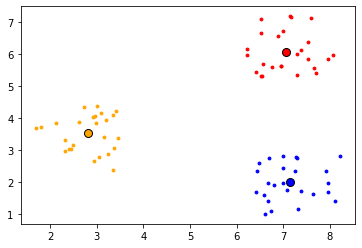

In [85]:
centroids = k_means(input_data, n_clusters)
cluster_colors = ["red", "orange", "blue"]
cluster_family = get_labels(input_data, centroids)

for i in range(n_clusters):
    plt.plot(centroids[i, 0], centroids[i, 1], marker="o", c=cluster_colors[i], markeredgecolor="black", markersize=8)
    plt.scatter(input_data[cluster_family==i, 0], input_data[cluster_family==i, 1], marker="o", c=cluster_colors[i], s=8)

Resources:
https://stanford.edu/~cpiech/cs221/handouts/kmeans.html